In [2]:
from googleapiclient.discovery import build
import re
import os
from dotenv import load_dotenv

In [3]:
API_KEY = os.getenv('GOOGLE_API_KEY')

In [4]:
VIDEO_URL = 'https://youtu.be/RSLnwpSfe-4?si=FESNRGXZdU52bUn8'

In [ ]:
def extract_video_id(url):
    pattern = r"(?:v=|\/)([0-9A-Za-z_-]{11}).*"
    match = re.search(pattern, url)
    return match.group(1) if match else None

In [6]:
video_id = extract_video_id(VIDEO_URL)
if not video_id:
    raise ValueError("Could not extract video ID from URL")

In [7]:
youtube = build("youtube", "v3", developerKey=API_KEY)

In [ ]:
def get_all_comments(video_id):
    comments = []
    request = youtube.commentThreads().list(
        part="snippet,replies",
        videoId=video_id,
        textFormat="plainText",
        maxResults=100  
    )
    while request:
        response = request.execute()
        for item in response.get("items", []):
            snippet = item["snippet"]["topLevelComment"]["snippet"]
            comments.append({
                "author": snippet.get("authorDisplayName"),
                "text": snippet.get("textDisplay"),
                "isReply": False
            })
            
            if "replies" in item:
                for reply in item["replies"]["comments"]:
                    rs = reply["snippet"]
                    comments.append({
                        "author": rs.get("authorDisplayName"),
                        "text": rs.get("textDisplay"),
                        "isReply": True
                    })
        request = youtube.commentThreads().list_next(request, response)
    return comments


In [17]:
all_comments = get_all_comments(video_id)

In [18]:
import pandas as pd

df = pd.DataFrame(all_comments)
df.to_csv("youtube_comments.csv", index=False)
print("Saved comments to youtube_comments.csv")


Saved comments to youtube_comments.csv


In [19]:
import joblib

vectorizer = joblib.load('tfidf_vectorizer.joblib')

In [20]:
import xgboost as xgb
model = xgb.XGBClassifier()
model.load_model('review_sentiment_model.json')






In [21]:
import re

def remove_html_tags(text):
    clean_text = re.sub(r'<.*?>', '', text)
    return clean_text

def preprocess_text(doc):
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    return ' '.join(tokens)



In [22]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [23]:

df['cleaned_text'] = df['text'].apply(remove_html_tags) 
docs = list(nlp.pipe(df['cleaned_text']))
df['processed_text'] = [preprocess_text(doc) for doc in docs]


In [24]:

youtube_features = vectorizer.transform(df['processed_text'])


In [ ]:

predictions = model.predict(youtube_features)
probabilities = model.predict_proba(youtube_features)


df['sentiment'] = predictions 
df['sentiment_label'] = df['sentiment'].map({0: 'negative', 1: 'positive'})
df['confidence'] = probabilities.max(axis=1) 


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Sentiment Distribution of YouTube Comments')

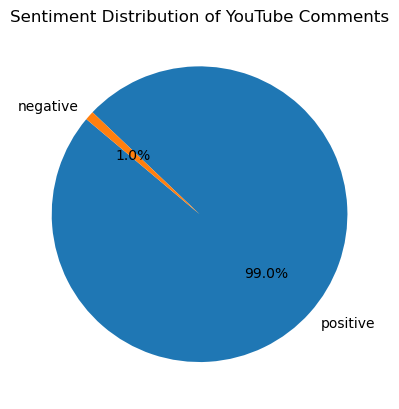

In [32]:
sentiment_counts = df['sentiment_label'].value_counts()

plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution of YouTube Comments')


In [38]:

positive_comments = df[
    (df['sentiment_label'] == 'positive') & 
    (df['confidence'] > 0.8)
].nlargest(5, 'confidence')

negative_comments = df[
    (df['sentiment_label'] == 'negative') & 
    (df['confidence'] > 0.8)
].nlargest(5, 'confidence')

print("Sample Positive Comments:")
for _, row in positive_comments.iterrows():
    print(f"- {row['text']} (Confidence: {row['confidence']:.2f})")
print("\nSample Negative Comments:")
for _, row in negative_comments.iterrows():
    print(f"- {row['text']} (Confidence: {row['confidence']:.2f})")

Sample Positive Comments:
- I love Season 5 so much! It is probably my favorite season ❤ (Confidence: 0.90)
- I love seeing them all together ❤ (Confidence: 0.83)
- I LOVE this season. (Confidence: 0.83)
- This truly was an amazing season. I mean all of them were, but this one just hit different. 💕 (Confidence: 0.82)
- The best season because of Mondler ❤ Could they BE any cuter? ❤ (Confidence: 0.82)

Sample Negative Comments:
